In [14]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import netCDF4
import xarray as xr
import pickle


## ---------------------------------------------------------------------------------------------------
## Inputs


Dimensions specified below

$\textit{m}$: length of the measurement vector

$\textit{n}$: length of the state (parameter) vector

$\textit{r}$: length of the model error vector


To perform this ICA, you'll need a few things:

1. Jacobian matrix, defined as the $ K_{j,i}(\textbf{x}) = \frac{\partial F_i (\textbf{x})}{\partial x_j}$ where $\textit{i}$ has length $\textit{m}$ and $\textit{j}$ has length $\textit{n}$. $F(\textbf{x})$ is the forward model at the state defined by $\textbf{x}$.

    jac [n x m]
    
2. Model error Jacobian matrix, defined as the $ K_{b,u,i}(\textbf{x}) = \frac{\partial F_i (\textbf{x})}{\partial b_u}$ where $\textit{i}$ has length $\textit{m}$ and $\textit{u}$ has length $\textit{r}$. $F(\textbf{x})$ is the forward model at the state defined by $\textbf{x}$. Note there are options in the Rodgers function to omit consideration of model errors if these are not known.

    jac_me [r x m]
    
3. Measurement error coveriance matrix, $S_{\epsilon}$. This can be specificed as either an $\textit{m}$ length vector of sigma squared measurement uncertainties or an $\textit{m} x \textit{m}$ full covariance matrix. In the former case, it is assumed that measurement uncertainty is uncorrelated. See meas_err() for a model to generate the error covariance matrix for a multi-angle polarimeter

    err [m x m] or [m]   

4. Model error coveriance matrix, $S_{b}$. This can be specificed as either an $\textit{r}$ length vector of sigma squared measurement uncertainties or an $\textit{r} x \textit{r}$ full covariance matrix. In the former case, it is assumed that measurement uncertainty is uncorrelated. Note there are options below to omit consideration of model errors if these are not known.

    err_me [m x m] or [m]   
    
5. A priori error coveriance matrix, $S_{a}$. This can be specificed as either an $\textit{n}$ length vector of sigma squared measurement uncertainties or an $\textit{n} x \textit{n}$ full covariance matrix. In the former case, it is assumed that measurement uncertainty is uncorrelated. 

    ap [n x n] or [n]   
    
6. If calculating the detection probability: the value of the parameter in question

    mu [scalar]
    
        

## ---------------------------------------------------------------------------------------------------

# Outputs


### from rodgers(jac, err, ap, model_error={}, model_error_jacobian={})
1. Error covariance matrix, $\hat{S}$.

    S_hat [n x n]
    
2. Shannon Information Content, $SIC$.

    SIC [scalar]
    
3. Averaging kernel matrix, $A$. 

    AvgK [n x n]

4. Degrees of Freedom for Signal, $DFS$. 

    DFS [scalar]  

    
### from detect_prob(mu, sigma)
1. Probability of detection, $P_d$. Note this requires inputs mu (parameter value in question) and sigma ($\sqrt{\hat{S}_{p,p}}$ where $p$ is the parameter index.)

    Pd [scalar]
    
    Pd_pcnt_str [percentage as string]


## ---------------------------------------------------------------------------------------------------
# Measurement error covariance matrix generation

aka $S_{\epsilon}$ or err

We are using a simplified form of the RSP instrument uncertainty model described in Appendix B of: 

Knobelspiesse, K., Tan, Q., Bruegge, C., Cairns, B., Chowdhary, J., van Diedenhoven, B., Diner, D., Ferrare, R., van Harten, G., Jovanovic, V., Ottaviani, M., Redemann, J., Seidel, F., and Sinclair, K.: Intercomparison of airborne multi-angle polarimeter observations from the Polarimeter Definition Experiment, Appl. Optics, 58(3), 650--669 , https://doi.org/10.1364/AO.58.000650, 2019.

with correlation in uncertainty as defined in:

Gao, M., Knobelspiesse, K., Franz, B. A., Zhai, P.-W., Cairns, B., Xu, X., and Martins, J. V.: The impact and estimation of uncertainty correlation for multi-angle polarimetric remote sensing of aerosols and ocean color, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2022-1413, 2022.

#### This is defined by three parameters

Radiometric characterization uncertainty: $\sigma_{cr} = 0.03 $ 

Polarimetric characterization uncertainty: $\sigma_{cp} = 0.005 $ 

Shot noise parameter: $\sigma_{s} = 0.0003 $ 

Correlation length parameter: $\theta_{c} = 20^{\circ} $ 

#### We also need to know instrument and measurement specific parameters:

Observation angle spacing: $\Delta_{\theta} $

Measurement reflectance: $R_{I,i}$

Measurement polarized reflectance: $R_{P,i}$

Measurement Degree of Linear Polarization (DoLP): $DoLP_{i}$

$i$ is an index to the specific measurement. 

#### The individual uncertainty for each of these measurements is:

Reflectance uncertainty: $ \sigma_{R_I,i}^2 = \sigma_{cr}^2 R_{I,i}^2 + \frac{1}{2} \sigma_{s}^2 R_{I,i} $

Polarized reflectance uncertainty: $ \sigma_{R_P,i}^2 = (\sigma_{cr}^2 + \sigma_{cp}^2 ) R_{P,i}^2 + 2 \sigma_{s}^2 R_{I,i}$

Degree of Linear Polarization uncertainty: $ \sigma_{DoLP,i}^2 = \sigma_{cp}^2 DoLP_{i}^2  + (2-DoLP^2) \frac{\sigma_{s}^2}{R_{I,i}} $

#### Filling the error covariance matrix

The abovementioned uncertainties are for each individual measurement (indexed by $i$), and fill the diagonal of the measurement error covaraince matrix $S_{\epsilon}$. Off diagonal terms are defined by the amount of measurement correlation. For multi-angle polarimeters like we are considering, there is angle-to-angle measurement correlation in the uncertainty of measurements in the same spectral channel and polarization state. The amount is defined by the correlation length parameter, $\theta_{c}$. 

So, for diagonal terms:

$S_{\epsilon,i,i} = \sigma_{t,i}^2 $

where $ \sigma_{t,i}^2 = [\sigma_{R_I,i}^2, \sigma_{R_P,i}^2, \sigma_{DoLP,i}^2 ]$
depending on if $i$ references $R_{I}$, $R_{P}$, or $DoLP$.

for off diagonal terms where $i$ and $j$ have the same spectral band and polarization state:

$S_{\epsilon,i,j} = \sigma_{t,i} \sigma_{t,j} e^{-\Delta_{\theta} |i-j| / \theta_{c}}$

Also, please note that shot noise is not expected to be correlated, so $\sigma_{t}$ is calculated assuming $\sigma_{s} = 0 $ for these off diagonal terms. 

and finally, for off diagonal terms where $i$ and $j$ do not have the same spectral band and polarization state:

$S_{\epsilon,i,j} = 0$

In [2]:
#creates a measurement error covariance matrix
# MEAS is the data containing either Ri, Rp or DoLP as specified in TYPEID. Array of m length
# REF is the reflectance data Ri corresponding to MEAS. Array of m length
# TYPE_ID identifies if individual REF contains Ri, Rp or DoLP and the spectral band from which the REF
#  index expresses. The purpose is to identify which uncertainty model to use, and identify if pairs of 
#  indicies refer to the same wavelength/polarization state. TYPEID is a number indicating the 
#  measurement type:
#     TYPEID=0 reflectance
#     TYPEID=1 polarized reflectance
#     TYPEID=2 DoLP
# WAVE_ID is an index to the wavelength in use. For correlation to occur, WAVID must be identical between pairs
# VZA_ID is the view zenith angle, in degrees, associated with each measurement. Array of m length
# SIG_CR is the radiometric calibration uncertainty, scalar
# SIG_CP is the polarimetric calibration uncertainty, scalar
# SIG_S is the shot noise parameter, scalar
# THE_C is the correlation length parameter, scalar
def make_err_cov(meas, ref, type_id, wave_id, vza_id, sig_cr=0.03, sig_cp=0.005, sig_s=0.0003, the_c=30.): 
    ln=np.shape(ref)
    ln=ln[0]
    
    err = np.zeros([ln, ln], dtype = float)
    
    #nested for loops and if statements are the slow way to do this, but easiest to verify for accuracy. 
    #Perhaps change if it turns out to be too slow
    
    
    for ii in range(0, ln):
        for jj in range (0, ln):
            if (type_id[ii] == type_id [jj]) and (wave_id[ii] == wave_id [jj]):
                if (ii == jj):                   
                    if np.mod(type_id[ii],10) == 0: #case for reflectance
                        err[ii,jj] = (sig_cr**2 * meas[ii]**2) + 0.5*(sig_s**2)*ref[ii]
                    elif np.mod(type_id[ii],10) == 1: #case for polarized reflectance 
                        err[ii,jj] = ((sig_cr**2 + sig_cp**2) * meas[ii]**2)  + (2.0*(sig_s**2)*ref[ii])
                    elif np.mod(type_id[ii],10) == 2: #case for DoLP
                        err[ii,jj] = (sig_cp**2)*(meas[ii]**2) + (2.0-(meas[ii]**2))*2.0*(sig_s**2)/ref[ii]
                    else: 
                        err[ii,jj] = np.nan                                         
                else:
                    exp_mult=np.exp(-1.0*np.abs(vza_id[ii]-vza_id[jj])/the_c)
                    
                    if np.mod(type_id[ii],10) == 0: #case for reflectance
                        err[ii,jj] = (sig_cr*meas[ii]) * (sig_cr*meas[jj]) * exp_mult
                    elif np.mod(type_id[ii],10) == 1: #case for polarized reflectance 
                        err[ii,jj] = (np.sqrt(sig_cr**2 + sig_cp**2) * meas[ii]) * \
                            (np.sqrt(sig_cr**2 + sig_cp**2) * meas[jj]) * exp_mult
                    elif np.mod(type_id[ii],10) == 2: #case for DoLP
                        err[ii,jj] = (sig_cp*meas[ii]) * (sig_cp*meas[jj]) * exp_mult
                    else: 
                        err[ii,jj] = np.nan      
    return err

In [3]:
#function to calculate the parameter (retrieval) error covariance matrix.

#input 
# JAC: Jacobian, K, [n x m]
# ERR: error covariance matrix Se, [m x m] 
# AP: a priori matrix Sa, [n x n]
#
#optional input - if values passed, add model uncertainty to estimate
# MODEL_ERROR
# MODEL_ERROR_JACOBIAN 
def rodgers(jac, err, ap, model_error={}, model_error_jacobian={}): 
    
        #check if error covariance matrix is square, or just diagonal values. If latter make full matrix
    if err.ndim == 1:
        ln=np.shape(err)
        err2d = np.zeros((ln[0], ln[0]))
        np.fill_diagonal(err2d, err)
        err=err2d

        #check if a priori covariance matrix is square, or just diagonal values. If latter make full matrix
    if ap.ndim == 1:
        ln=np.shape(ap)
        ap2d = np.zeros((ln[0], ln[0]))
        np.fill_diagonal(ap2d, ap)
        ap=ap2d        
            
        #section to verify compatable dimensions ------------------------------------------------------
    sh_jac = np.shape(jac)
    sh_err = np.shape(err)
    sh_ap = np.shape(ap)
    
    n_dim = sh_jac[0]
    m_dim = sh_jac[1]
    
    if not((sh_err[0] == sh_err[1]) and (sh_ap[0] == sh_ap[1])):
        print('ERROR: error covariance matrix or a priori matrix are not square')
        print('Error covariance matrix dimensions')
        print(sh_err)
        print('A priori matrix dimensions')
        print(sh_ap)
        return -1, -1, -1, -1
    
    if not(sh_jac[0] == sh_ap[0]):
        print('ERROR: n dimensions inconsistent, should be Jacobian [n x m]; a priori [n x n]')
        print('Jacobian matrix dimensions')
        print(sh_jac)
        print('A priori matrix dimensions')
        print(sh_ap)
        return -1, -1, -1, -1
    
    if not(sh_jac[1] == sh_err[0]):
        print('ERROR: m dimensions inconsistent, should be Jacobian [n x m]; error covariance [m x m]')
        print('Jacobian matrix dimensions')
        print(sh_jac)
        print('Error covariance matrix dimensions')
        print(sh_err)
        return -1, -1, -1, -1
        
    #section to generate model derived error -------------------------------------------------------  
    if len(model_error) > 0:
        me=model_error
        jac_me=model_error_jacobian
        
        ln_me=np.shape(me)
        errme_2d = np.zeros((ln_me[0], ln_me[0]))
        np.fill_diagonal(errme_2d, me)
        err_me=errme_2d
    
        jac_me_t=np.transpose(jac_me)      
    
        JacmetMeJacme = np.matmul(jac_me_t,np.matmul(err_me,jac_me))
        err = err + JacmetMeJacme
    
        #perform inverse and matrix multiplication calculations ----------------------------------------
    jac_t=np.transpose(jac) #transpose of Jacobian (KT)
    
    try: 
        err_i=np.linalg.inv(err) #inverse of error covariance matrix (Se-1)
    except:
        print("ERROR: problem inverting error covariance matrix")
        return -1, -1, -1, -1
    
    try: 
        ap_i=np.linalg.inv(ap) #inverse of a priori error covariance matrix
    except:
        print("ERROR: problem inverting a priori covariance matrix")
        return -1, -1, -1, -1

    KtSK = np.matmul(jac,np.matmul(err_i,jac_t)) #calcuates KT Se-1 K

    try: 
        S_hat = np.linalg.inv(KtSK+ap_i) #calculate the inverse of (above + Sa-1)
    except:
        print("ERROR: problem inverting retrieval error covariance matrix")
        return -1, -1, -1, -1
    
    SIC = 0.5*np.log(np.linalg.det(np.matmul((KtSK+ap_i),ap))) #calculate Shannon Information Content    
    AvgK = np.matmul(S_hat,KtSK) #averaging kernel
    DFS = np.trace(AvgK) #degrees of freedom for signal (DFS) which is trace of averaging kernel
    
    return S_hat, SIC, AvgK, DFS  #returns retrieval error covariance matrix and the Shannon Information Content

In [4]:
#calculates the probability of detection given the parameter value (mu) and uncertainty (sigma)
#assumes PDF is gaussian normally distributed
def detect_prob(mu, sigma, doprint=0): 

    Pd = 1-0.5*(1+erf((-1*mu)/(sigma*np.sqrt(2))))  #detection probability, modified from CDF function

    Pd_pcnt_str=str(np.around(Pd*100,decimals=1))+'% positive probability' #string output version

    if doprint > 0:
        print(Pd_pcnt_str)

    return Pd, Pd_pcnt_str

In [5]:
#calculate detection probability metrics for a full range of fractional plastic coverage. 
#Also, return result at 95% or whatever is specified in fraction_threshold variable
def detect_prob_all(plastic_uncertainty,plastic_fraction,fraction_threshold=0.95):    

    #make array of values to assess (val) and dummy array to fill (det_prob)
    inc=np.arange(0, 10000, 1)
    val=inc/10000
    det_prob=np.arange(0, 10000, 1) / 10000
       
    #interpolate plastic_uncertainty to assessment values
    plastic_uncertainty_int = np.interp(val,plastic_fraction,plastic_uncertainty)    
    
    for x in inc:
        Pd, Pd_pcnt_str = detect_prob(val[x], plastic_uncertainty_int[x], doprint=0)
        det_prob[x] = Pd

    #get plastic fraction for a fraction_threshold detection probability 
    fraction_meeting_threshold = np.interp(fraction_threshold,det_prob,val)
    
    return det_prob, fraction_meeting_threshold
            

In [6]:
def print_out(S_hat, SIC, AvgK, DFS, jac, err, ap, me_err, numpts, params, me_params ):

    S_hat_diag=np.diagonal(S_hat)
    uncert=np.sqrt(S_hat_diag)

    np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    print('Error covariance matrix:')
    print(S_hat)
    print()

    np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
    print('Averaging kernel matrix:')
    print(AvgK)
    print()
    np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
    print('Model Parameters:       ', params)
    print('Number of observations: ', numpts)
    print('A priori uncertainty:   ', np.sqrt(ap))
    print('Uncertainties:          ', uncert)
    print('Shannon Information Content:      ', SIC)
    print('Degrees of freedom for signal:    ', DFS)

## Section to read simulated dataset

In [7]:
#input/output and other specifics

#file_in='simulations/Jacek/Jacobian.nc'
#file_in='simulations/Jacek/sunglint_HARP2_jacobian_combined.nc'
file_in='simulations/Jacek/sunglint_microplastic_jacobian_V2.nc'

#parameter order: wnd, tau, fplastic, chl

rel_err = np.array([0.01587401, 0.01244266, 0.00938955, 0.01092051, 0.00302288,
    0.00544271, 0.00999068, 0.01467843, 0.0080387, 0.00944394,
    0.0193447, 0.0224503, 0.02386379])
sys_err = np.zeros(13)

rel_err = rel_err*2.



In [8]:
#read netcdf4 file with simulation
f = netCDF4.Dataset(file_in)
#                                    0             1           2      3      4      5      6       7       8
# read jacobian double Jac_I(wavelength=4, parameter=4, fplastic=5, wnd=3, tau=4, chl=2, sun=3, azim=4, view=58);
#jac needs to be [index, measurement, parameter]        

jac_dolp = np.asarray(f.variables['DoLP'])
jac_i = np.asarray(f.variables['I'])
jac_q = np.asarray(f.variables['Q'])
jac_u = np.asarray(f.variables['U'])
jac_rp = np.asarray(f.variables['Rp'])

ref_dolp = np.asarray(f.variables['ref_DoLP'])
ref_i = np.asarray(f.variables['ref_I'])
ref_q = np.asarray(f.variables['ref_Q'])
ref_u = np.asarray(f.variables['ref_U'])
ref_rp = np.asarray(f.variables['ref_Rp'])

jac_dims=np.shape(jac_dolp)
# z (#cases,), m (measurent), n (param) lengths
z_len=jac_dims[2] * jac_dims[3] * jac_dims[4] * jac_dims[5] * jac_dims[6] * jac_dims[7]
m_len=jac_dims[1]*jac_dims[8]*3 # num. wavelength * num. view angles * num. polarization states
p_len=jac_dims[0]

jac_all = np.zeros([z_len,m_len,p_len])
meas = np.zeros([z_len,m_len])
waveln = np.asarray(f.variables['wavelength'])
wnd = np.asarray(f.variables['wnd'])
tau = np.asarray(f.variables['tau'])
chl = np.asarray(f.variables['chl'])
fplastic = np.asarray(f.variables['fplastic'])
sun = np.asarray(f.variables['sun'])
azim = np.asarray(f.variables['azim'])  #note this is RELATIVE azimuth angle
view = np.asarray(f.variables['view'])  #this includes negative and positive values

#close netcdf file
f.close()


In [9]:
print(np.shape(jac_dolp))
print(np.shape(jac_i))
print(np.shape(jac_all))
print(waveln)

#Checks for NaN's in the input data and reports location

#Jac_I(parameter=4, wavelength=4, fplastic=5, wnd=3, tau=4, Chl=2, sun=5, azim=4, view=5);
for i_fplastic in range(0, fplastic.size):   #case for cross-principal plane (azim = 90, 270)
    for i_wnd in range(0, wnd.size):
        for i_tau in range(0, tau.size):
            for i_chl in range(0, chl.size):
                for i_sun in range(0, sun.size):                  
                    for i_param in range(0,4):
                        for i_waveln in range(0,waveln.size):
                            if np.isnan(jac_rp[i_param,i_waveln,i_fplastic,i_wnd,i_tau,i_chl,i_sun,0,:]).any():
                                print('Nan found in index ', i_param, i_waveln, i_fplastic, i_wnd, i_tau, i_chl, i_sun)


(4, 4, 5, 3, 4, 2, 3, 4, 58)
(4, 4, 5, 3, 4, 2, 3, 4, 58)
(1440, 696, 4)
[442 547 666 867]


In [10]:
#read the simulation specific parameters into a dataframe, and convert jacobian from 8D to 3D

#read jacobian double Jac_I(parameter=4, wavelength=4, fplastic=5, wnd=3, tau=4, Chl=2, sun=5, azim=4, view=5);
#jac needs to be [index, measurement, parameter]    

# TYPEID identifies if individual REF contains Ri, Rp or DoLP and the spectral band from which the REF
#  index expresses. The purpose is to identify which uncertainty model to use, and identify if pairs of 
#  indicies refer to the same wavelength/polarization state. TYPEID is a number indicating the 
#  measurement type:
#     TYPEID=0 reflectance
#     TYPEID=1 polarized reflectance
#     TYPEID=2 DoLP
# WAVEID is an index to the wavelength in use. For correlation to occur, WAVID must be identical between pairs
# VZAID is the view zenith angle, in degrees, associated with each measurement. Array of m length


df = pd.DataFrame(columns=['Windspeed(m_s)', 'Humidity(%)', 'FMF', 'AOD(867)', 'chla(mg_m3)', 
                           'plastic_fraction', 'solz', 'relaz', 'senz','plastic_uncertainty',
                           'SIC', 'plastic_avgK', 'DFS'])

idx=0

jac_all=np.empty((z_len, m_len, p_len))  #jacobian matrix
sim_all=np.empty((z_len, m_len, p_len))  #corresponding simulation matrix
ref_all=np.empty((z_len, m_len, p_len))  #reflectance only portion of the simulation associated with this


typeid = np.concatenate( [np.full(view.size*waveln.size, fill_value=0), \
                             np.full(view.size*waveln.size, fill_value=1), \
                             np.full(view.size*waveln.size, fill_value=2)])  
waveid=np.tile(np.repeat(waveln,view.size),3)
vzaid=np.tile(view,waveln.size*3)

   
for i_fplastic in range(0, fplastic.size):   
    for i_wnd in range(0, wnd.size):
        for i_tau in range(0, tau.size):
            for i_chl in range(0, chl.size):
                for i_sun in range(0, sun.size):
                    for i_azim in range(0, azim.size):                        
                        df.loc[idx]=[wnd[i_wnd],0,0.5,tau[i_tau],chl[i_chl],fplastic[i_fplastic],sun[i_sun],
                                     azim[i_azim],np.nan,np.nan,np.nan,np.nan,np.nan]                    
                        for i_param in range(0,p_len):
                            #portion for jacobian
                            ints = jac_i[:,i_param,i_fplastic,i_wnd,i_tau,i_chl,i_sun,i_azim,:].flatten()
                            polr = jac_rp[:,i_param,i_fplastic,i_wnd,i_tau,i_chl,i_sun,i_azim,:].flatten()
                            dolp = jac_dolp[:,i_param,i_fplastic,i_wnd,i_tau,i_chl,i_sun,i_azim,:].flatten()                            
                            jac_all[idx,:,i_param]=np.concatenate([ints, polr, dolp]) 
                            #portion for reference
                            ints = ref_i[:,i_param,i_fplastic,i_wnd,i_tau,i_chl,i_sun,i_azim,:].flatten()
                            polr = ref_rp[:,i_param,i_fplastic,i_wnd,i_tau,i_chl,i_sun,i_azim,:].flatten()
                            dolp = ref_dolp[:,i_param,i_fplastic,i_wnd,i_tau,i_chl,i_sun,i_azim,:].flatten()
                            sim_all[idx,:,i_param]=np.concatenate([ints,polr,dolp]) 
                            ref_all[idx,:,i_param]=np.concatenate([ints,ints,ints])  
                        
                        idx +=1




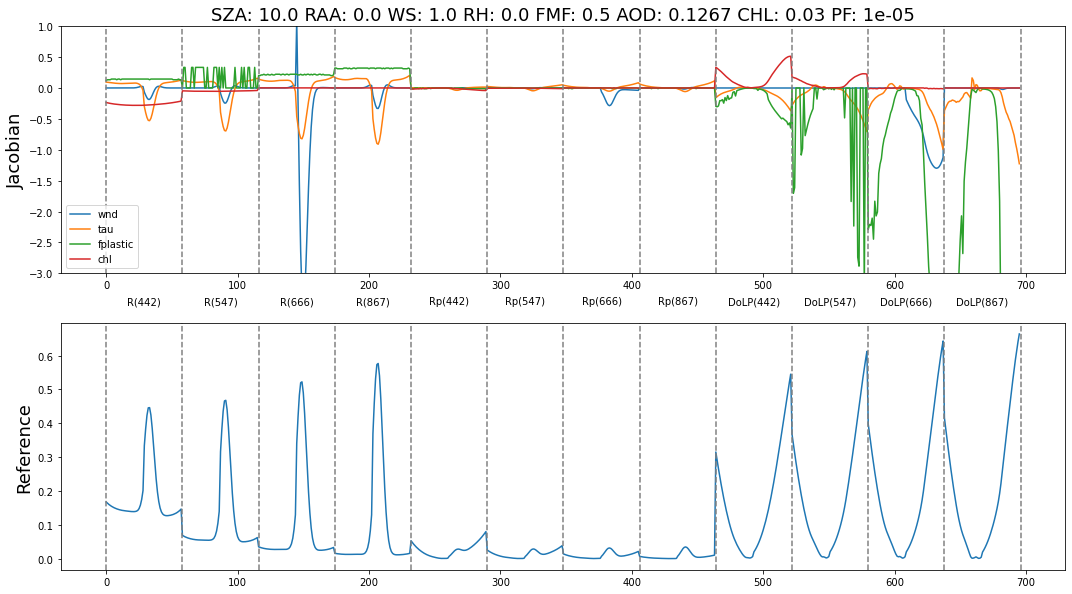

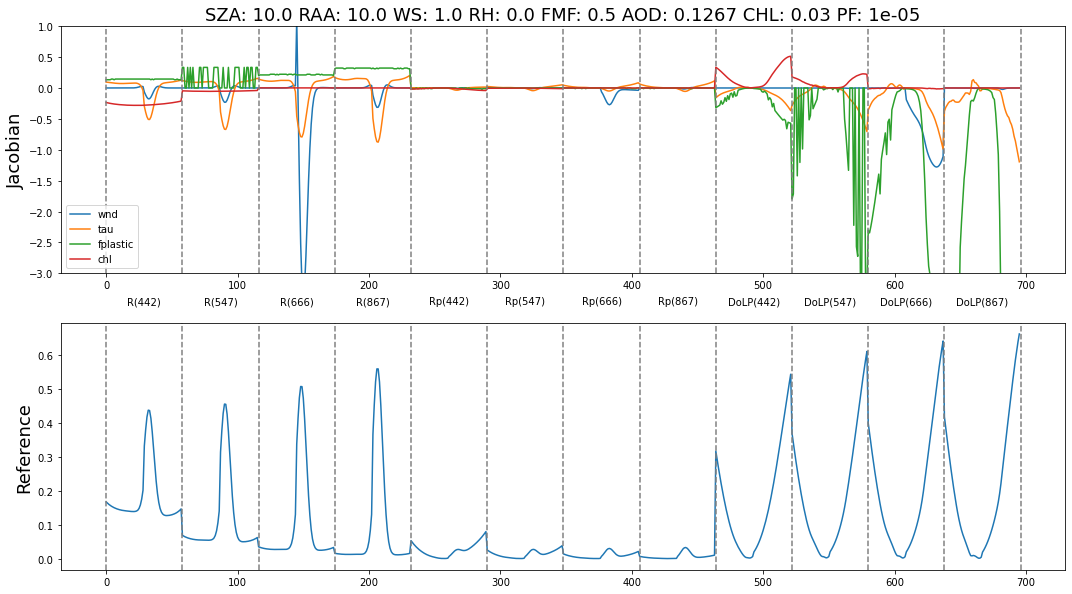

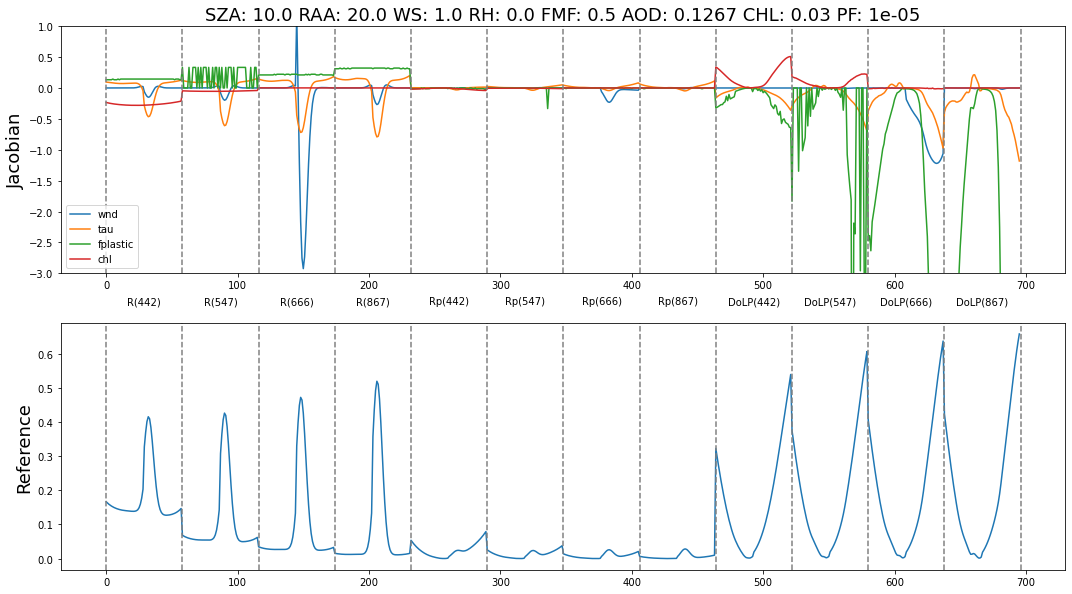

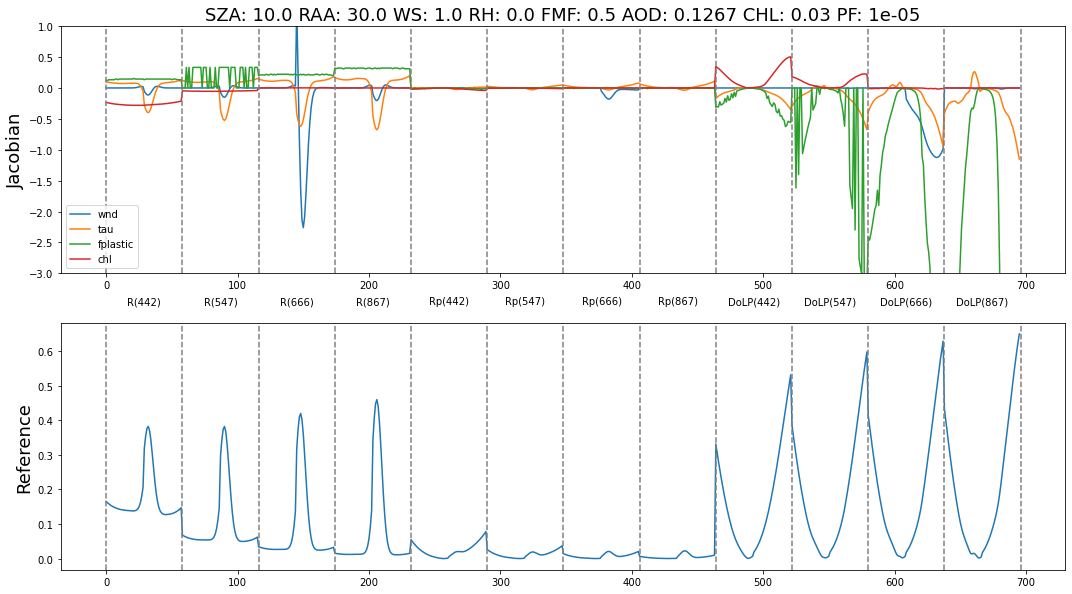

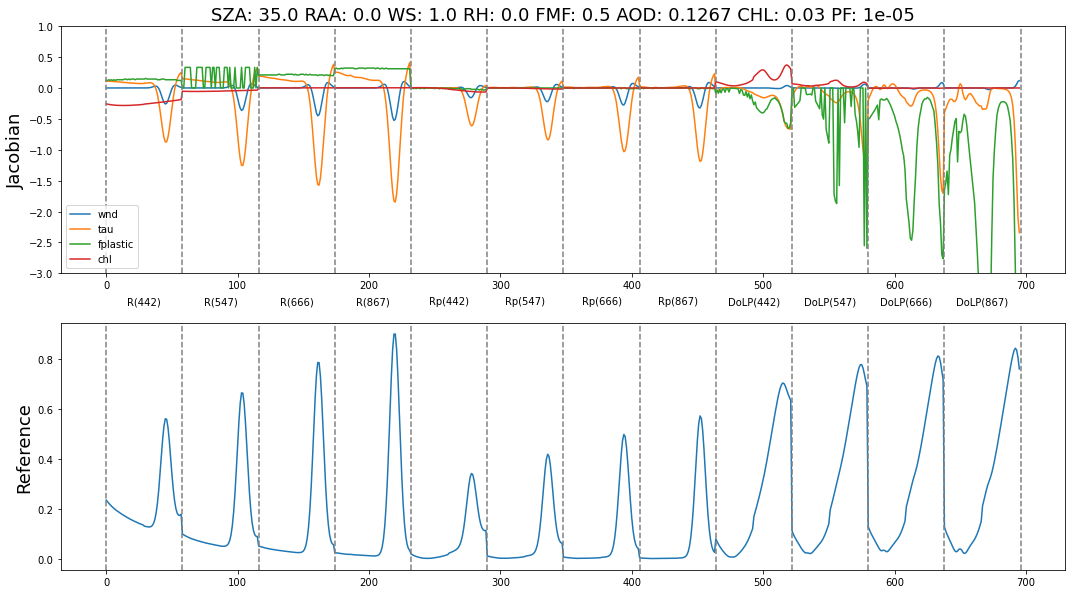

In [13]:
#section to plot jacobians. Takes a while if all are plotted

#for plt_z in range(0, z_len):
for plt_z in range(0, 5):
    
    wd=jac_dims[8]
    lbl=['R(442)','R(547)','R(666)','R(867)','Rp(442)','Rp(547)','Rp(666)','Rp(867)', \
         'DoLP(442)','DoLP(547)','DoLP(666)','DoLP(867)','']
    
    plt.figure(figsize=(18,10))

    #titl='FMF: ' + str(df.FMF.loc[plt_z])  
    titl='SZA: ' + str(df.iloc[plt_z,6]) + ' RAA: ' + str(df.iloc[plt_z,7]) + ' WS: ' + str(df.iloc[plt_z,0]) \
        + ' RH: ' + str(df.iloc[plt_z,1]) + ' FMF: ' + str(df.iloc[plt_z,2]) + ' AOD: ' + str(df.iloc[plt_z,3]) \
        + ' CHL: ' + str(df.iloc[plt_z,4]) + ' PF: ' + str(df.iloc[plt_z,5])

    plt.subplot(2, 1, 1)
    #plt.suptitle(titl,fontsize=18)

    plt.plot(jac_all[plt_z,:,0],label='wnd')
    plt.plot(jac_all[plt_z,:,1],label='tau')
    plt.plot(jac_all[plt_z,:,2],label='fplastic')
    plt.plot(jac_all[plt_z,:,3],label='chl')
    # set the title to subplots
    plt.gca().set_title(titl,fontsize=18)
    plt.gca().set_ylabel('Jacobian',fontsize=18)
    for i_wave in range(0,(waveln.size*3+1)):
        plt.axvline(x = wd*i_wave, color='grey',linestyle='dashed')
        plt.text((wd*i_wave)+(wd/2), -3.5, lbl[i_wave], ha='center')
    plt.ylim(-3, 1)
    plt.legend(loc="lower left")
    
    plt.subplot(2, 1, 2)
    plt.plot(sim_all[plt_z,:,0])
    plt.gca().set_ylabel('Reference',fontsize=18)
    for i_wave in range(0,(waveln.size*3+1)):
        plt.axvline(x = wd*i_wave, color='grey',linestyle='dashed')
    #plt.ylim(-1, 1)

    outname='figures/SQOOP_Jacek_v03/JacobianPlot_'+str(plt_z)+'.pdf'
    plt.savefig(outname)   
    plt.show()  



In [ ]:
#make a priori covariance matrix from range of simulation values

#ap=(np.linspace(10.0,10.0,4))**2 #generate a priori error covariance matrix
WS_range=df['Windspeed(m_s)'].max() - df['Windspeed(m_s)'].min()
RH_range=df['Humidity(%)'].max() - df['Humidity(%)'].min()
FMF_range=df['FMF'].max() - df['FMF'].min()
AOD_range=df['AOD(867)'].max() - df['AOD(867)'].min()
CHL_range=df['chla(mg_m3)'].max() - df['chla(mg_m3)'].min()
PF_range=df['plastic_fraction'].max() - df['plastic_fraction'].min()


#ap=np.asarray([WS_range,RH_range,FMF_range,AOD_range,CHL_range,PF_range]) #generate a priori error covariance matrix
ap=np.asarray([WS_range,AOD_range,CHL_range,0.5]) #generate a priori error covariance matrix

ap=(ap/2)**2 #generate a priori error covariance matrix diagonals

print(ap)

In [25]:
#subset jacobian and measurement data for desired test

#this particular configuration takes all view angles for the the
#hyperangle channel (666) and 8 otherwise. It also uses just Ref_I
#and DoLP

use_id_a = np.mod(vzaid,7) == 0 #select for 8 view angles only
use_id_b = waveid == 666 # identify hyperangle channel
use_id_c = np.logical_or(use_id_a, use_id_b).flatten()

use_id_d = np.mod(typeid,2) == 0 #select for only Ref_I and DOLP
use_id = np.logical_and(use_id_c, use_id_d).flatten() # <----- this is the variable to select data

#apply subsetting to relevant datasets
typeid_sub=typeid[use_id]
waveid_sub=waveid[use_id]
vzaid_sub=vzaid[use_id]
m_sub_len=np.shape(vzaid_sub)
m_sub_len=m_sub_len[0]

jac_sub=jac_all[:,use_id]
sim_sub=sim_all[:,use_id]
ref_sub=ref_all[:,use_id]

In [26]:
#make error covariance matrix 
err_cov=np.empty((z_len, m_sub_len, m_sub_len))

for idx in range(0, z_len):
    err_cov[idx,:,:]= \
        make_err_cov(sim_sub[idx,:,0].flatten(), ref_sub[idx,:,0].flatten(), \
                     typeid_sub, waveid_sub, vzaid_sub, sig_cr=0.03, sig_cp=0.005, sig_s=0.0003, the_c=30.)
    if np.mod(idx,100) == 0:
        print(idx)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [38]:
#plt.figure(figsize=(10,10))
#plt.imshow(np.squeeze(err_cov[1408,:,:]))

In [27]:
#run Rodgers information content routine

for idx in range(0, z_len):
#for idx in range(0, 2):
    #calculate rodgers stuff
    
    S_hat, SIC, AvgK, DFS = rodgers(np.transpose(np.squeeze(jac_sub[idx,:,:])), np.squeeze(err_cov[idx,:,:]), ap)

    df.loc[idx]["plastic_uncertainty"]=np.sqrt(S_hat[3,3]) 
    df.loc[idx]["SIC"]=SIC
    df.loc[idx]["plastic_avgK"]=AvgK[3,3]
    df.loc[idx]["DFS"]=DFS

df_orig=df.copy()    

df

,Windspeed(m_s),Humidity(%),FMF,AOD(867),chla(mg_m3),plastic_fraction,solz,relaz,senz,plastic_uncertainty,SIC,plastic_avgK,DFS
0,1.0,0.0,0.5,0.1267,0.03,0.00001,10.0,0.0,NaN,0.003564,26.931229,0.999797,3.999792
1,1.0,0.0,0.5,0.1267,0.03,0.00001,10.0,10.0,NaN,0.003570,26.655734,0.999796,3.999791
2,1.0,0.0,0.5,0.1267,0.03,0.00001,10.0,20.0,NaN,0.003571,26.576051,0.999796,3.999791
3,1.0,0.0,0.5,0.1267,0.03,0.00001,10.0,30.0,NaN,0.003589,26.196528,0.999794,3.999787
4,1.0,0.0,0.5,0.1267,0.03,0.00001,35.0,0.0,NaN,0.004716,23.834112,0.999644,3.999635
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,10.0,0.0,0.5,1.2668,1.00,0.10000,35.0,30.0,NaN,0.243839,12.321019,0.048678,3.033331
1436,10.0,0.0,0.5,1.2668,1.00,0.10000,60.0,0.0,NaN,0.245390,14.151527,0.036542,3.034059
1437,10.0,0.0,0.5,1.2668,1.00,0.10000,60.0,10.0,NaN,0.245374,13.798250,0.036665,3.032497
1438,10.0,0.0,0.5,1.2668,1.00,0.10000,60.0,20.0,NaN,0.245178,13.054975,0.038204,3.027004


In [40]:
#iterate through each set of conditions that have all the same parameter value except for plastic fraction. 
#create a new dataframe, and save one row for each set, with median values for plastic_uncertainty, SIC, plastic_avgK and DFS
#also, assess detection probability and save the plastic fraction value for 90% confident probability.

df.sort_values(by=['Windspeed(m_s)','Humidity(%)','FMF','AOD(867)','chla(mg_m3)','solz','relaz'], inplace=True)

df.rename(columns={'plastic_fraction': 'plastic_threshold', 'plastic_uncertainty': 'plastic_unc_median', 'SIC': 'SIC_median', \
                   'plastic_avgK':'plastic_avgK_median', 'DFS': 'DFS_median'}, inplace=True)


fdf = df.copy()
fdfe = fdf[0:0]

incr=fplastic.size #increment for set of microplastic value simulations

for idx in range(0, z_len-incr, incr):
    if (idx % 1000) == 0:
        txt=str(idx)+' of '+str(z_len)
        print(txt)
    
    #get start and end points for this iteration
    st=idx
    ed=idx+incr

    this=df.iloc[st:ed]

    this_plastic_fraction = np.asarray(df.iloc[st:ed]['plastic_threshold'])   
    this_plastic_uncertainty = np.asarray(df.iloc[st:ed]['plastic_unc_median'])   
    
    this_detect_prob, fraction_meeting_threshold = \
        detect_prob_all(this_plastic_uncertainty,this_plastic_fraction,fraction_threshold=0.95)

    fdfe = fdfe.append(df.iloc[st], ignore_index = True)
        
    fdfe.loc[fdfe.index[-1], 'plastic_threshold']= fraction_meeting_threshold
    
    #section to update field with median values for set
    fdfe.loc[fdfe.index[-1], 'plastic_unc_median']= np.median(this_plastic_uncertainty)
    fdfe.loc[fdfe.index[-1], 'SIC_median']= np.median(np.asarray(df.iloc[st:ed]['SIC_median']))
    fdfe.loc[fdfe.index[-1], 'plastic_avgK_median']= np.median(np.asarray(df.iloc[st:ed]['plastic_avgK_median']))
    fdfe.loc[fdfe.index[-1], 'DFS_median']= np.median(np.asarray(df.iloc[st:ed]['DFS_median']))
    


#change names in original df back
df.rename(columns={'plastic_threshold':'plastic_fraction', 'plastic_unc_median':'plastic_uncertainty', 'SIC_median':'SIC', \
                   'plastic_avgK_median':'plastic_avgK', 'DFS_median':'DFS'}, inplace=True)


fdfe

0 of 1440
1000 of 1440


,Windspeed(m_s),Humidity(%),FMF,AOD(867),chla(mg_m3),plastic_threshold,solz,relaz,senz,plastic_unc_median,SIC_median,plastic_avgK_median,DFS_median
0,1.0,0.0,0.5,0.1267,0.03,0.005928,10.0,0.0,NaN,0.003571,26.408431,0.999796,3.999790
1,1.0,0.0,0.5,0.1267,0.03,0.005924,10.0,10.0,NaN,0.003574,26.390359,0.999796,3.999789
2,1.0,0.0,0.5,0.1267,0.03,0.005926,10.0,20.0,NaN,0.003576,26.359669,0.999795,3.999789
3,1.0,0.0,0.5,0.1267,0.03,0.005938,10.0,30.0,NaN,0.003589,26.196528,0.999794,3.999787
4,1.0,0.0,0.5,0.1267,0.03,0.007802,35.0,0.0,NaN,0.004716,23.381112,0.999644,3.999634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,10.0,0.0,0.5,1.2668,1.00,0.401160,35.0,20.0,NaN,0.245490,12.920432,0.035757,3.025081
283,10.0,0.0,0.5,1.2668,1.00,0.401080,35.0,30.0,NaN,0.245398,12.591853,0.036477,3.018921
284,10.0,0.0,0.5,1.2668,1.00,0.403630,60.0,0.0,NaN,0.246530,14.320834,0.027569,3.025824
285,10.0,0.0,0.5,1.2668,1.00,0.403604,60.0,10.0,NaN,0.246480,13.952979,0.027961,3.024544


In [42]:
# save dataframes to pickle files
outname='data/SQOOP_Jacek_v1'

df_name=outname+'_df.pkl'
fdfe_name=outname+'_fdfe.pkl'
fdfe_csv_name=outname+'_fdfe.csv'
vars_name=outname+'_vars.pkl'

df.to_pickle(df_name)
fdfe.to_pickle(fdfe_name) 

f = open(vars_name, 'wb')
pickle.dump([waveln,meas,rel_err,sys_err,jac_all],f)
f.close()

fdfe.to_csv(fdfe_csv_name)
